<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_GAN/blob/master/GAN_mnist_LSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Conv2D, Dense, BatchNormalization, Flatten, LeakyReLU, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential, optimizers, metrics

import matplotlib.pyplot as plt

import tensorflow_probability as tfp
ds = tfp.distributions

from functools import reduce

In [16]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

In [17]:
x_train.shape[0]

60000

In [18]:
batch_size = 256
noise_dim = 100
lr = 1e-4

In [19]:
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(x_train.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices(x_test).shuffle(x_test.shape[0]).batch(batch_size)
test_data

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

generator = Generator(gen_net=gen_net, noise=noise, optimizer=optimizer)

In [20]:
class GAN(keras.Model):

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.generator = Sequential(self.gen_nn)    
        self.discriminator = Sequential(self.dis_nn)
        self.cross_entropy = self.cross_entropy
        self.noise_z = self.noise

    def Generator(self, x, training):
        if training == True:
            gen = self.generator(x, training=True)
        else:
            gen = self.generator(x, training=False)
        return gen 

    def Discriminator(self, x):
        dis = self.discriminator(x, training=True)
        return dis

    @tf.function
    def dis_loss(self, real_output, fake_output):
        # total_loss = -tf.reduce_sum(tf.math.log(real_output) + tf.math.log(tf.ones_like(fake_output) - fake_output))

        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss
    
    @tf.function
    def gen_loss(self, fake_output):
        # loss = -tf.reduce_mean(tf.math.log(fake_output))
        
        loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)
        return loss

        
    @tf.function
    def compute_gradient(self, x):
        noise = self.noise_z

        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
            generated_img = self.Generator(noise, True)

            real_output = self.Discriminator(x)
            fake_output = self.Discriminator(generated_img)

            loss_gen = self.gen_loss(fake_output)
            loss_dis = self.dis_loss(real_output, fake_output)

        gradient_gen = gen_tape.gradient(loss_gen, self.generator.trainable_variables)
        gradient_dis = dis_tape.gradient(loss_dis, self.discriminator.trainable_variables)

        return gradient_gen, gradient_dis, loss_gen, loss_dis

    @tf.function
    def train(self, x):
        gradient_gen, gradient_dis, loss_gen, loss_dis = self.compute_gradient(x)
        self.gen_optimizer.apply_gradients(zip(gradient_gen, self.generator.trainable_variables))
        self.dis_optimizer.apply_gradients(zip(gradient_dis, self.discriminator.trainable_variables))
        return loss_gen, loss_dis



In [21]:
gen_nn = [Dense(7*7*256, input_shape=(100,)),
          BatchNormalization(),
          LeakyReLU(),
          
          Reshape((7,7,256)),
          Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
          BatchNormalization(),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
          BatchNormalization(),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')]

dis_nn = [Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
          LeakyReLU(),
          Dropout(0.3),
          
          Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
          LeakyReLU(),
          Dropout(0.3),
          
          Flatten(),
          Dense(1)]

optimizer = optimizers.Adam(learning_rate=lr)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
noise = tf.random.normal([batch_size, noise_dim])

In [22]:
gen_network = GAN(gen_nn=gen_nn, 
                  dis_nn=dis_nn, 
                  noise=noise, 
                  gen_optimizer=optimizer, 
                  dis_optimizer=optimizer, 
                  cross_entropy=cross_entropy)

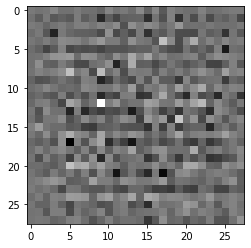

In [23]:
# geerate random noise img
noise_ = tf.random.normal([1, 100])
generated_img = gen_network.Generator(noise_, False)
plt.imshow(generated_img[0, :, :, 0], cmap='gray')


In [24]:
decision = gen_network.Discriminator(generated_img)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00127931]], dtype=float32)>

In [25]:
train_gen_loss = metrics.Mean(name='train_generator_loss')
train_dis_loss = metrics.Mean(name='train_discriminator_loss')
test_gen_loss = metrics.Mean(name='test_generator_loss')
test_dis_loss = metrics.Mean(name='test_discriminator_loss')

In [26]:
def show_generated_img(model, epoch, test_data):
    predict = model.Generator(test_data, False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predict.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predict[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [27]:
def show_loss(gen, dis, tgen, tdis, epoch):
    plt.plot(epoch, gen, label='gen train')
    plt.plot(epoch, tgen, label='gen test')
    plt.plot(epoch, dis, label='dis train')
    plt.plot(epoch, tdis, label='dis test')
    plt.legend()
    plt.show()


Epoch: 0, Gen[train]: 1.446803331375122, Dis[train]: 0.922631561756134, Gen[test]: 1.4540562629699707, Dis[test]: 0.8231202363967896 


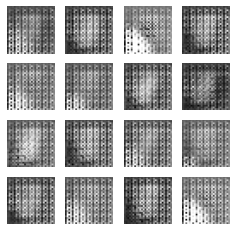

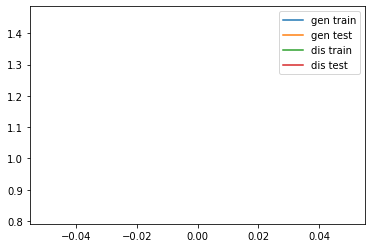

time: 16.355817079544067 
Epoch: 1, Gen[train]: 1.1529202461242676, Dis[train]: 1.0709728002548218, Gen[test]: 1.057695984840393, Dis[test]: 1.1449158191680908 
Epoch: 2, Gen[train]: 1.1486340761184692, Dis[train]: 1.0739624500274658, Gen[test]: 1.100568413734436, Dis[test]: 1.2372182607650757 
Epoch: 3, Gen[train]: 1.2909103631973267, Dis[train]: 0.947806715965271, Gen[test]: 1.2416536808013916, Dis[test]: 0.921237587928772 
Epoch: 4, Gen[train]: 1.3939865827560425, Dis[train]: 0.812768816947937, Gen[test]: 1.3661202192306519, Dis[test]: 0.8049031496047974 
Epoch: 5, Gen[train]: 1.5884369611740112, Dis[train]: 0.7116692066192627, Gen[test]: 1.724058747291565, Dis[test]: 0.6530812978744507 
Epoch: 6, Gen[train]: 1.6667883396148682, Dis[train]: 0.6567413210868835, Gen[test]: 1.801314115524292, Dis[test]: 0.557263970375061 
Epoch: 7, Gen[train]: 1.8110542297363281, Dis[train]: 0.6184953451156616, Gen[test]: 1.8453747034072876, Dis[test]: 0.5887237787246704 
Epoch: 8, Gen[train]: 1.863346

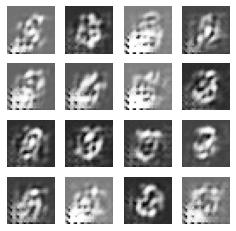

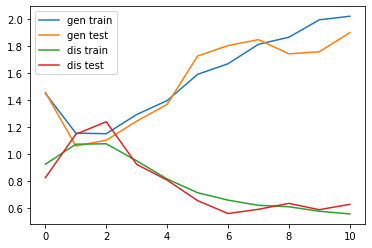

time: 146.18045830726624 
Epoch: 11, Gen[train]: 2.0576765537261963, Dis[train]: 0.5466490387916565, Gen[test]: 1.9596350193023682, Dis[test]: 0.5611594915390015 
Epoch: 12, Gen[train]: 2.1066315174102783, Dis[train]: 0.5301912426948547, Gen[test]: 2.054414749145508, Dis[test]: 0.5311427712440491 
Epoch: 13, Gen[train]: 2.1195294857025146, Dis[train]: 0.5386660695075989, Gen[test]: 2.0430636405944824, Dis[test]: 0.5537422299385071 
Epoch: 14, Gen[train]: 2.208507537841797, Dis[train]: 0.5144432783126831, Gen[test]: 2.1410269737243652, Dis[test]: 0.4819716513156891 
Epoch: 15, Gen[train]: 2.2363059520721436, Dis[train]: 0.5101721286773682, Gen[test]: 2.1359174251556396, Dis[test]: 0.5587338209152222 
Epoch: 16, Gen[train]: 2.2570579051971436, Dis[train]: 0.5125030875205994, Gen[test]: 2.4921345710754395, Dis[test]: 0.4520961344242096 
Epoch: 17, Gen[train]: 2.321099281311035, Dis[train]: 0.48947784304618835, Gen[test]: 2.262970447540283, Dis[test]: 0.5061296224594116 
Epoch: 18, Gen[tra

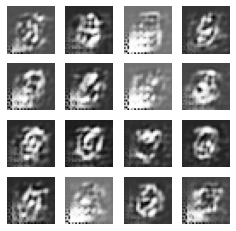

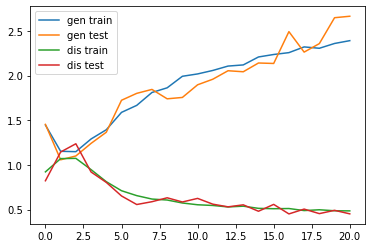

time: 275.29273438453674 
Epoch: 21, Gen[train]: 2.4190797805786133, Dis[train]: 0.4775463044643402, Gen[test]: 2.4856619834899902, Dis[test]: 0.49605947732925415 
Epoch: 22, Gen[train]: 2.4697649478912354, Dis[train]: 0.4702814817428589, Gen[test]: 2.436642646789551, Dis[test]: 0.49934816360473633 
Epoch: 23, Gen[train]: 2.4809024333953857, Dis[train]: 0.4778504967689514, Gen[test]: 2.6643471717834473, Dis[test]: 0.470320463180542 
Epoch: 24, Gen[train]: 2.5099477767944336, Dis[train]: 0.46823158860206604, Gen[test]: 2.6087043285369873, Dis[test]: 0.45258742570877075 
Epoch: 25, Gen[train]: 2.5596771240234375, Dis[train]: 0.4652095437049866, Gen[test]: 2.303433418273926, Dis[test]: 0.4859349727630615 
Epoch: 26, Gen[train]: 2.5702130794525146, Dis[train]: 0.4587346315383911, Gen[test]: 2.6676712036132812, Dis[test]: 0.44480982422828674 
Epoch: 27, Gen[train]: 2.641160011291504, Dis[train]: 0.4477521479129791, Gen[test]: 2.4728004932403564, Dis[test]: 0.4737825393676758 
Epoch: 28, Gen

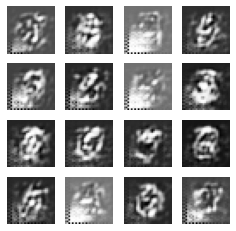

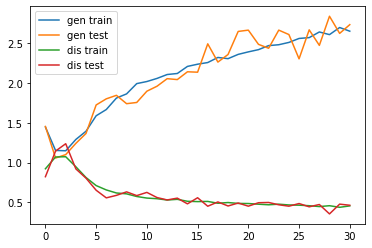

time: 404.2027049064636 
Epoch: 31, Gen[train]: 2.704430341720581, Dis[train]: 0.44489362835884094, Gen[test]: 2.753696918487549, Dis[test]: 0.4515068531036377 
Epoch: 32, Gen[train]: 2.7521190643310547, Dis[train]: 0.43807539343833923, Gen[test]: 3.055781364440918, Dis[test]: 0.44319337606430054 
Epoch: 33, Gen[train]: 2.773763656616211, Dis[train]: 0.4391113519668579, Gen[test]: 2.6606733798980713, Dis[test]: 0.4664939343929291 
Epoch: 34, Gen[train]: 2.76511812210083, Dis[train]: 0.4403621256351471, Gen[test]: 2.854192018508911, Dis[test]: 0.45196014642715454 
Epoch: 35, Gen[train]: 2.7842702865600586, Dis[train]: 0.43407055735588074, Gen[test]: 2.8650548458099365, Dis[test]: 0.45329371094703674 
Epoch: 36, Gen[train]: 2.8490819931030273, Dis[train]: 0.42124438285827637, Gen[test]: 2.886221408843994, Dis[test]: 0.417581170797348 
Epoch: 37, Gen[train]: 2.8483386039733887, Dis[train]: 0.42829662561416626, Gen[test]: 2.364016056060791, Dis[test]: 0.4523228704929352 
Epoch: 38, Gen[tra

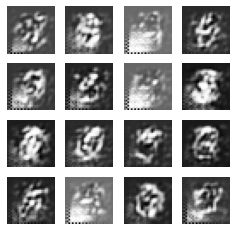

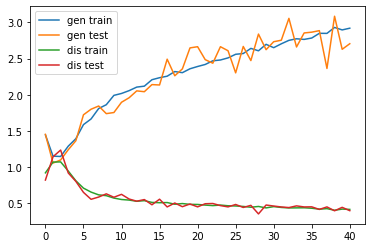

time: 533.1764500141144 
Epoch: 41, Gen[train]: 2.9785640239715576, Dis[train]: 0.40053069591522217, Gen[test]: 2.4564132690429688, Dis[test]: 0.4508039951324463 
Epoch: 42, Gen[train]: 2.9684042930603027, Dis[train]: 0.40632885694503784, Gen[test]: 3.139047145843506, Dis[test]: 0.3929440379142761 
Epoch: 43, Gen[train]: 3.0504133701324463, Dis[train]: 0.39302709698677063, Gen[test]: 3.1963741779327393, Dis[test]: 0.39307641983032227 
Epoch: 44, Gen[train]: 3.028787136077881, Dis[train]: 0.3968712389469147, Gen[test]: 4.246488094329834, Dis[test]: 0.34881147742271423 
Epoch: 45, Gen[train]: 3.019345760345459, Dis[train]: 0.4053504765033722, Gen[test]: 3.5949885845184326, Dis[test]: 0.40444135665893555 
Epoch: 46, Gen[train]: 3.0583083629608154, Dis[train]: 0.3961701989173889, Gen[test]: 2.728717803955078, Dis[test]: 0.4133569300174713 
Epoch: 47, Gen[train]: 3.0294177532196045, Dis[train]: 0.4061768651008606, Gen[test]: 2.7407805919647217, Dis[test]: 0.4228772222995758 
Epoch: 48, Gen[

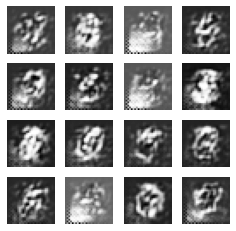

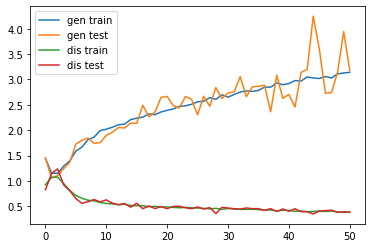

time: 661.9049048423767 
Epoch: 51, Gen[train]: 3.141341209411621, Dis[train]: 0.3823181986808777, Gen[test]: 3.291292190551758, Dis[test]: 0.41927894949913025 
Epoch: 52, Gen[train]: 3.1295275688171387, Dis[train]: 0.38872769474983215, Gen[test]: 2.6478419303894043, Dis[test]: 0.4376041293144226 
Epoch: 53, Gen[train]: 3.1692399978637695, Dis[train]: 0.3787851631641388, Gen[test]: 2.1865146160125732, Dis[test]: 0.5087505578994751 
Epoch: 54, Gen[train]: 3.1929984092712402, Dis[train]: 0.3815750777721405, Gen[test]: 3.29809308052063, Dis[test]: 0.34854692220687866 
Epoch: 55, Gen[train]: 3.155465602874756, Dis[train]: 0.3921145498752594, Gen[test]: 2.848532199859619, Dis[test]: 0.4090645909309387 
Epoch: 56, Gen[train]: 3.1983232498168945, Dis[train]: 0.3792862892150879, Gen[test]: 3.028581380844116, Dis[test]: 0.377289354801178 
Epoch: 57, Gen[train]: 3.1676509380340576, Dis[train]: 0.3860725462436676, Gen[test]: 3.3471317291259766, Dis[test]: 0.3950395882129669 
Epoch: 58, Gen[train]

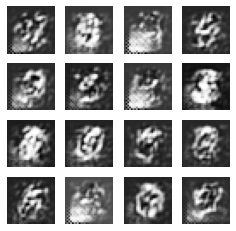

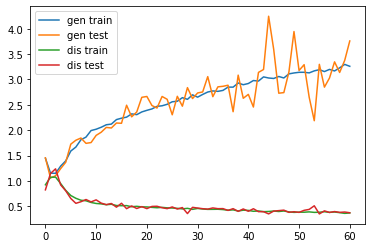

time: 790.6690804958344 
Epoch: 61, Gen[train]: 3.2718658447265625, Dis[train]: 0.3634842038154602, Gen[test]: 2.984276294708252, Dis[test]: 0.3768066167831421 
Epoch: 62, Gen[train]: 3.228504180908203, Dis[train]: 0.3751240074634552, Gen[test]: 3.7305774688720703, Dis[test]: 0.3329916000366211 
Epoch: 63, Gen[train]: 3.287362813949585, Dis[train]: 0.372022420167923, Gen[test]: 3.151740789413452, Dis[test]: 0.3939502239227295 
Epoch: 64, Gen[train]: 3.355325937271118, Dis[train]: 0.35319602489471436, Gen[test]: 3.7733871936798096, Dis[test]: 0.3230384290218353 
Epoch: 65, Gen[train]: 3.3674747943878174, Dis[train]: 0.3538607656955719, Gen[test]: 3.6705455780029297, Dis[test]: 0.29229825735092163 
Epoch: 66, Gen[train]: 3.4492006301879883, Dis[train]: 0.332049697637558, Gen[test]: 3.667570114135742, Dis[test]: 0.36828240752220154 
Epoch: 67, Gen[train]: 3.3755550384521484, Dis[train]: 0.34429991245269775, Gen[test]: 2.7427821159362793, Dis[test]: 0.38825833797454834 
Epoch: 68, Gen[trai

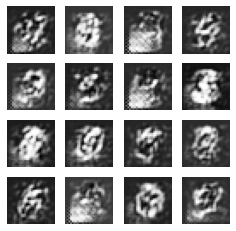

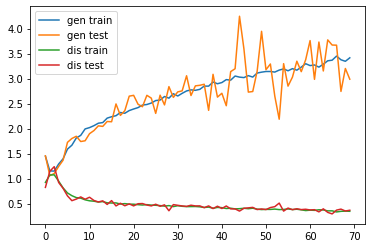

time: 906.8797075748444 


In [28]:
import time
display_step = 10
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_range = 70
gen_loss_arr = []
dis_loss_arr = []
gen_tloss_arr = []
dis_tloss_arr = []
EPOCH=[]

strat_time = time.time()
for epoch in range(train_range):
    for x_batch in train_data:
        gen_loss, dis_loss = gen_network.train(x_batch)
        train_gen_loss(gen_loss)
        train_dis_loss(dis_loss)

    for x_batch in test_data:
        a,b, loss_gen_t, loss_dis_t = gen_network.compute_gradient(x_batch)
        test_gen_loss(loss_gen_t)
        test_dis_loss(loss_dis_t)
    
    gen_loss_arr.append(train_gen_loss.result())
    dis_loss_arr.append(train_dis_loss.result())
    gen_tloss_arr.append(test_gen_loss.result())
    dis_tloss_arr.append(test_dis_loss.result())
    EPOCH.append(epoch)


    print(f'Epoch: {epoch}, Gen[train]: {train_gen_loss.result()}, Dis[train]: {train_dis_loss.result()}, Gen[test]: {test_gen_loss.result()}, Dis[test]: {test_dis_loss.result()} ')

    if epoch % display_step == 0 or epoch == (train_range - 1):
        show_generated_img(gen_network, epoch + 1, seed)
        show_loss(gen_loss_arr, dis_loss_arr, gen_tloss_arr, dis_tloss_arr, EPOCH)
        print(f'time: {time.time() - strat_time} ')

    train_gen_loss.reset_states()
    train_dis_loss.reset_states()
    test_gen_loss.reset_states()
    test_dis_loss.reset_states()